In [1]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib as mpl
import seaborn as sns
import numpy as np
import math

In [2]:
ROOT_PATH = "../../results/1744992824"

min_results_path = f"{ROOT_PATH}/min_top_category_usage_group_500_200_10_0_0.35_0.7_1_0.95.json"
mean_results_path = f"{ROOT_PATH}/mean_top_category_usage_group_500_200_10_0_0.35_0.7_1_0.95.json"
cvar_results_path = f"{ROOT_PATH}/cvar_top_category_usage_group_500_200_10_0_0.35_0.7_1_0.95.json"

with open(min_results_path, "r") as f:
    min_results = json.load(f)

with open(mean_results_path, "r") as f:
    mean_results = json.load(f)

with open(cvar_results_path, "r") as f:
    cvar_results = json.load(f)

In [3]:
def plot_methods_results_per_gamma(
    all_results: dict[str, dict],
    groups_key: str,
    n_consumers: int,
    n_producers: int,
    n_runs: int,
    k_rec: int,
    save_path,
) -> None:
    sns.set_style("whitegrid")
    mpl.rc('font', **{'size': 14})
    plt.rcParams["font.family"] = "Times New Roman"
    n_methods = len(all_results)
    fig, axes = plt.subplots(1, n_methods, figsize=(5*n_methods, 5), dpi=300)


    if n_methods == 1:
        axes = [axes]
    palette = sns.color_palette("colorblind", len(next(iter(all_results.values())).keys()))
    sns.set_palette(palette)

    for ax, (method_name, results) in zip(axes, all_results.items()):
        z = 1
        max_z = len(results)
        for group_name, group_results in results.items():
            alpha, alpha_results = next(iter(group_results.items()))
            xs, ys, ye = [], [], []
            for gamma, runs in sorted(alpha_results.items()):
                run_means = [np.mean(run) for run in runs]
                xs.append(gamma)
                ys.append(np.mean(run_means))
                ye.append(np.std(run_means) / np.sqrt(len(runs)))

            if group_name == "all":
                ax.plot(xs, ys, color="black", linestyle="--", marker="s", markersize=4,
                        zorder=max_z, label="Mean", linewidth=2)
            else:
                ax.plot(xs, ys, label=group_name.replace("_", " ").capitalize(),
                        marker=".", markersize=4, zorder=z, linewidth=2)
                ax.fill_between(xs, np.array(ys)-np.array(ye), np.array(ys)+np.array(ye),
                                alpha=0.05, zorder=z)
                z += 1

        ax.set_title(method_name.replace("_", " "))

    # centered x‑label moved closer
    fig.supxlabel(
        r"Fraction of best min producer utility guaranteed, $\gamma$",
        x=0.5, y=0.15, ha="center"
    )
    # shift the y‑label further left
    fig.supylabel(
        "Normalized consumer utility",
        x=0.01,
        y=0.6,
        ha="center"
    )

    # collect legend entries
    handles, labels = axes[-1].get_legend_handles_labels()
    n_labels = len(labels)
    n_rows = 4
    n_cols = math.ceil(n_labels / n_rows)
    # place legend lower to avoid overlap
    fig.legend(
        handles, labels, title="Groups",
        loc='lower center', bbox_to_anchor=(0.5, -0.21),
        ncol=n_cols, frameon=False, markerscale=1
    )

    # adjust layout for legend and labels
    fig.tight_layout(rect=[0, 0.18, 1, 0.93])
    # centered title
    fig.suptitle(
        'Consumer–Producer Utility Tradeoff',
        x=0.5, y=1, fontsize=16, fontweight='bold'
    )

    # save to file
    filename = f"results_per_gamma_{groups_key}_{n_consumers}_{n_producers}_{n_runs}_{k_rec}.pdf"
    save_path.mkdir(parents=True, exist_ok=True)
    plt.savefig(save_path / filename, bbox_inches='tight')


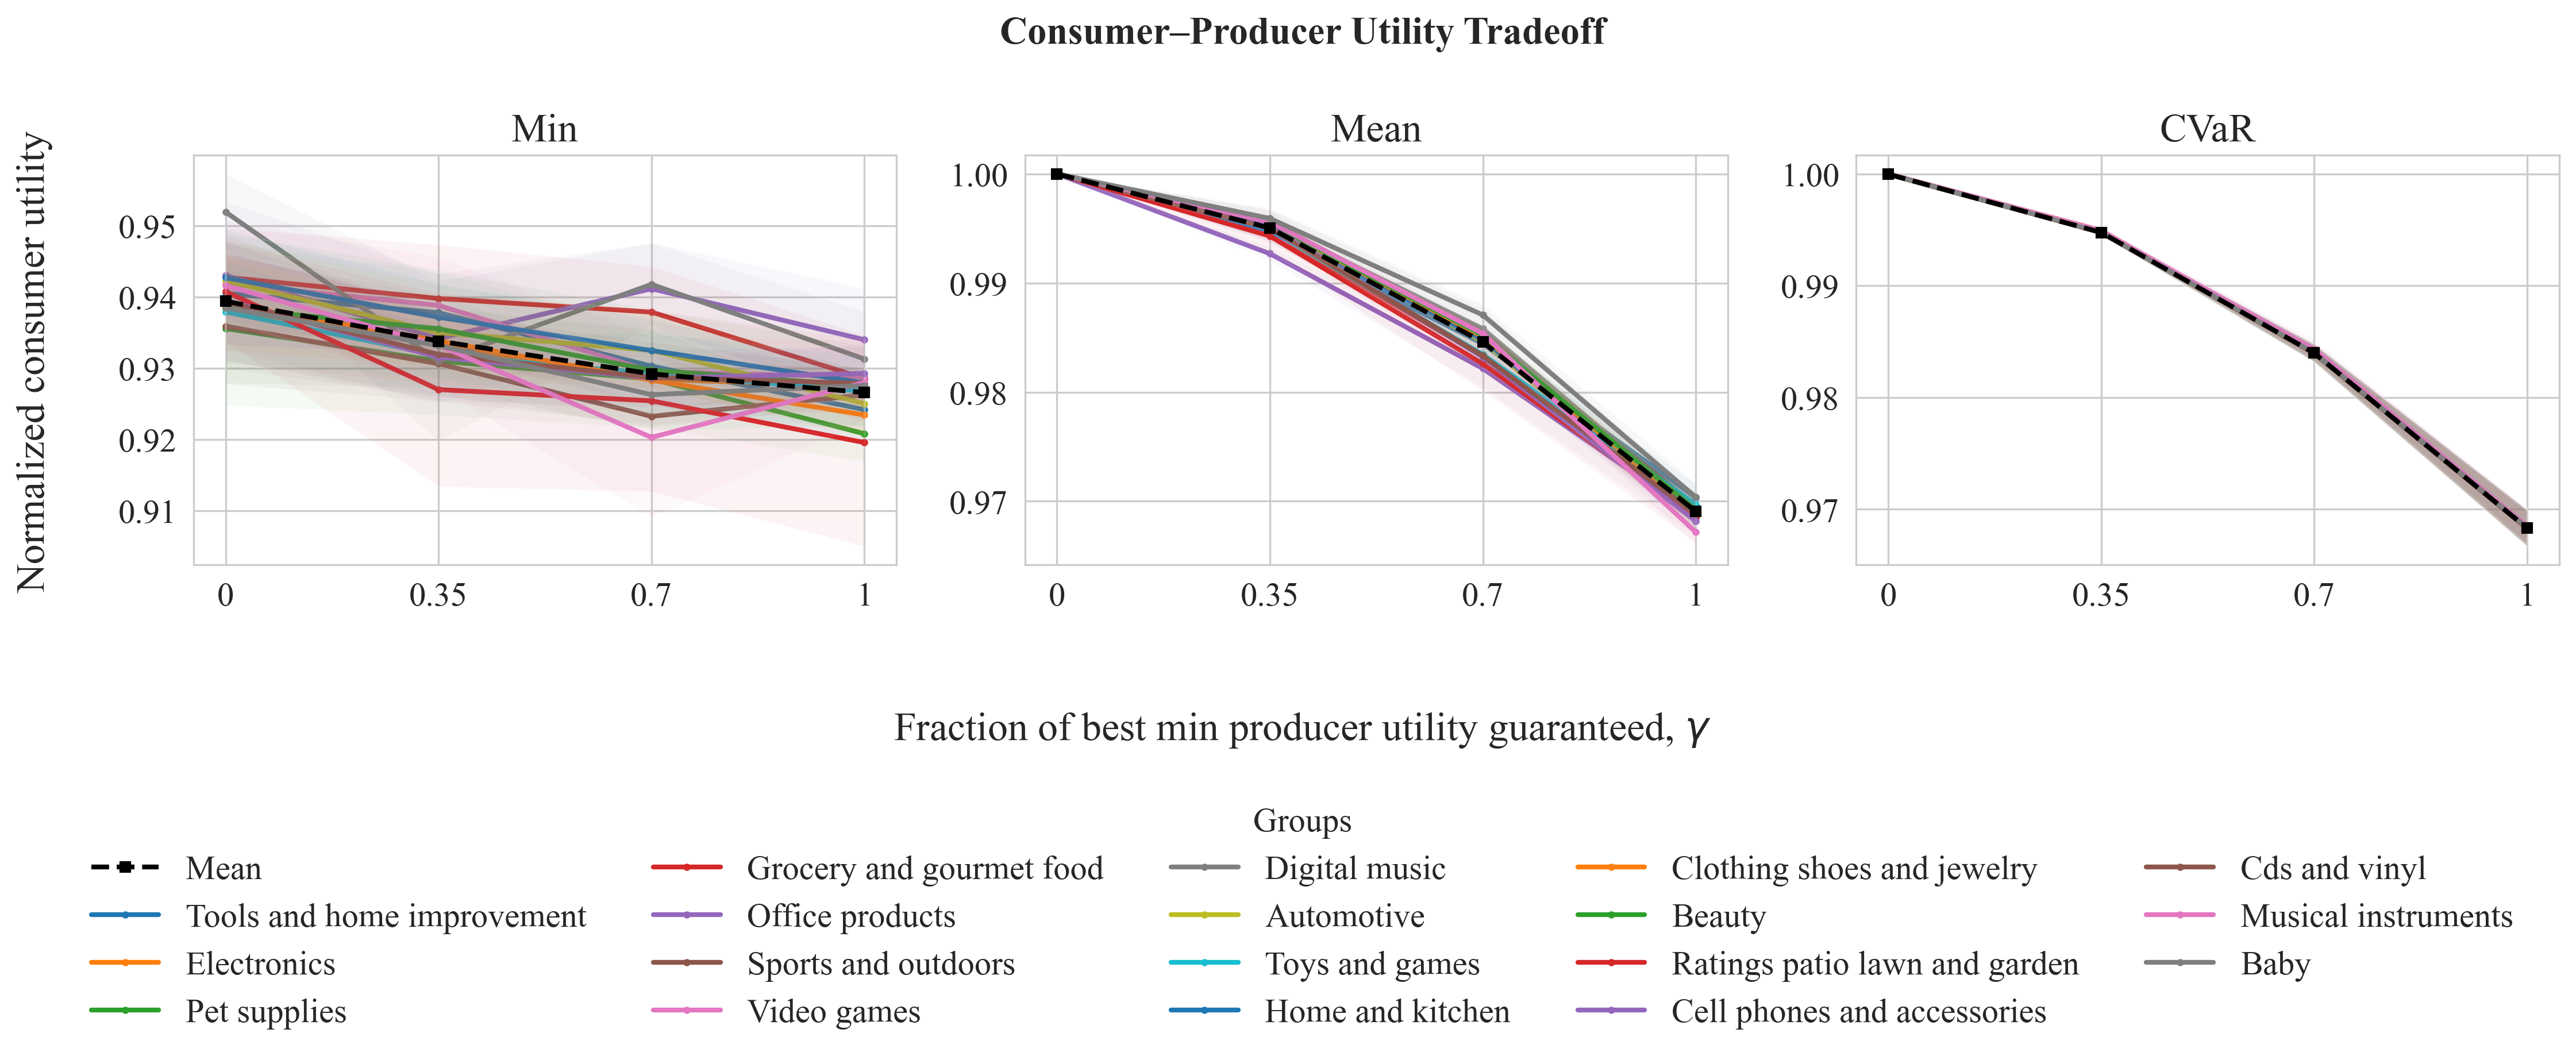

In [4]:
plot_methods_results_per_gamma(
    {
        "Min": min_results["results"]["top_category"],
        "Mean": mean_results["results"]["top_category"],
        "CVaR": cvar_results["results"]["top_category"],
    },
    "top_category",
    n_consumers=500,
    n_producers=200,
    n_runs=5,
    k_rec=10,
    save_path=Path("results")
)